In [1]:
# hot encode months or change them into 4 seasons 
# changing p days into binary variable 

def load_raw_data():

    from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder
    import pandas as pd
    import numpy as np
    from sklearn.model_selection import train_test_split
    
    train = pd.read_parquet("C:\\Users\\lgbra\\OneDrive\\Desktop\\VScode\\train_banking_marketing.parquet")
    test= pd.read_parquet("C:\\Users\\lgbra\\OneDrive\\Desktop\\VScode\\test-banking_marketing.parquet")
    
    combined_df = pd.concat([train,test])
    combined_df
    
    training_data, testing_data = train_test_split(combined_df,test_size = .1,random_state = 42)

    training_data = training_data
    testing_data = testing_data
    

    features_tr = training_data.drop(columns = ["y"])
    features_te = testing_data.drop(columns = ["y"])
    features_tr['pdays'] = np.where(features_tr['pdays'] == -1, "no", "yes")
    features_te['pdays'] = np.where(features_te['pdays'] == -1, "no", "yes")


    hot_encoder = OneHotEncoder(sparse_output = False).set_output(transform="pandas")
    ord_encoder = OrdinalEncoder().set_output(transform = "pandas")

    bin_cat_tr = features_tr[["default","housing","loan","pdays"]]
    multi_cat_tr = features_tr[["job","marital","education","contact","poutcome","month"]]

    multi_cat_encoded_tr = hot_encoder.fit_transform(multi_cat_tr)
    bin_cat_encoded_tr = ord_encoder.fit_transform(bin_cat_tr)
    numeric_tr = features_tr[["age","balance","duration","campaign","previous"]]

    x_tr = pd.concat([bin_cat_encoded_tr,multi_cat_encoded_tr,numeric_tr],axis = 1)
    y_tr = np.where(training_data["y"] == "yes", 1,0)
    
    bin_cat_te = features_te[["default","housing","loan","pdays"]]
    multi_cat_te = features_te[["job","marital","education","contact","poutcome","month"]]

    multi_cat_encoded_te = hot_encoder.transform(multi_cat_te)
    bin_cat_encoded_te = ord_encoder.transform(bin_cat_te)
    numeric_te = features_te[["age","balance","duration","campaign","previous"]]

    x_te = pd.concat([bin_cat_encoded_te,multi_cat_encoded_te,numeric_te],axis = 1)
    y_te = np.where(testing_data["y"] == "yes", 1,0)
    
    
    return x_tr,x_te,y_tr,y_te,bin_cat_encoded_tr,multi_cat_encoded_tr,bin_cat_encoded_te,multi_cat_encoded_te,training_data,numeric_tr,numeric_te

In [3]:
# function for converting pdays to categorical
def data_transform(df):
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import PowerTransformer,StandardScaler,MinMaxScaler
    import pandas as pd
    bin_cat = df[["default","housing","loan","pdays"]]

    multi_cat = df[['job_admin.', 'job_blue-collar',
        'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
        'job_self-employed', 'job_services', 'job_student', 'job_technician',
        'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married',
        'marital_single', 'education_primary', 'education_secondary',
        'education_tertiary', 'education_unknown', 'contact_cellular',
        'contact_telephone', 'contact_unknown', 'poutcome_failure',
        'poutcome_other', 'poutcome_success', 'poutcome_unknown','month_apr',
       'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
       'month_sep']]
    
    numeric = df[["age","balance","duration","campaign","previous"]]

# Let's try min/max scalar
    pipe_trans = Pipeline([("transform",PowerTransformer(method = "yeo-johnson")),("scale",StandardScaler())])
    numeric_trans = pipe_trans.fit(numeric).transform(numeric)
    numeric_df = pd.DataFrame(numeric_trans, columns=numeric.columns, index=numeric.index)
    

    return pd.concat([bin_cat,multi_cat,numeric_df],axis = 1)


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import History
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np

In [4]:
x_tr,x_te,y_tr,y_te,bin_cat_encoded_tr,multi_cat_encoded_tr,bin_cat_encoded_te,multi_cat_encoded_te,training_data,numeric_tr,numeric_te = load_raw_data()
x_tr = data_transform(x_tr)
x_te = data_transform(x_te)

In [54]:
# Define the model
model = Sequential()
model.add(Dense(16, input_shape=(47,), activation='relu'))
model.add((Dropout(.25)))
model.add(Dense(32, activation='relu'))
model.add((Dropout(.25)))
model.add(Dense(1, activation='sigmoid'))
model.summary()

C:\Users\lgbra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 16)             │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,345 (5.25 KB)

 Trainable params: 1,345 (5.25 KB)

 Non-trainable params: 0 (0.00 B)

In [57]:
# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
# Create a History object for callbacks to store the loss and accuracy
history = History()

# Train the model with validation data
model.fit(x_tr, y_tr,
          epochs=30,
          batch_size=20,
          verbose=2,
          validation_split=.1,
          callbacks=[history])


Epoch 1/30
2015/2015 - 4s - 2ms/step - accuracy: 0.9077 - loss: 0.2087 - val_accuracy: 0.9100 - val_loss: 0.2041
Epoch 2/30
2015/2015 - 3s - 2ms/step - accuracy: 0.9067 - loss: 0.2105 - val_accuracy: 0.9129 - val_loss: 0.2031
Epoch 3/30
2015/2015 - 4s - 2ms/step - accuracy: 0.9060 - loss: 0.2087 - val_accuracy: 0.9124 - val_loss: 0.2002
Epoch 4/30
2015/2015 - 4s - 2ms/step - accuracy: 0.9071 - loss: 0.2095 - val_accuracy: 0.9111 - val_loss: 0.2029
Epoch 5/30
2015/2015 - 4s - 2ms/step - accuracy: 0.9069 - loss: 0.2083 - val_accuracy: 0.9106 - val_loss: 0.2025
Epoch 6/30
2015/2015 - 4s - 2ms/step - accuracy: 0.9067 - loss: 0.2082 - val_accuracy: 0.9095 - val_loss: 0.2036
Epoch 7/30
2015/2015 - 3s - 2ms/step - accuracy: 0.9066 - loss: 0.2079 - val_accuracy: 0.9120 - val_loss: 0.2017
Epoch 8/30
2015/2015 - 3s - 1ms/step - accuracy: 0.9081 - loss: 0.2070 - val_accuracy: 0.9122 - val_loss: 0.2014
Epoch 9/30
2015/2015 - 4s - 2ms/step - accuracy: 0.9072 - loss: 0.2079 - val_accuracy: 0.9120 - 

#### **Inference - Test Set**

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

predictions = model.predict(x_te,batch_size = 100,verbose=0)
rounded_predictions = (predictions > .5).astype(int)

nn_pred = confusion_matrix(y_te, rounded_predictions)
ConfusionMatrixDisplay(nn_pred).plot(cmap='viridis')


#### **Using an automated Hyper Param Tuner**

In [95]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_model(hp):
    model = Sequential()
    model.add(Dense(hp.Int('units_1', min_value=32, max_value=512, step=32), activation='relu'))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.3, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=hp.Choice('learning_rate', values=[.1,1e-2, 1e-3, 1e-4]))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Initialize a new tuner
tuner = kt.BayesianOptimization(
    build_model,
    objective = 'val_accuracy',
    max_trials =20,  # Adjust as needed
    num_initial_points=2,
    directory='resultssss',  # Change the directory to avoid loading old tuner
    project_name='keras_tuner_bayesian'
)

# Start the search from scratch
tuner.search(x_tr, y_tr, epochs=5, validation_split=0.2)

# Optionally, retrieve the best model after search
best_model = tuner.get_best_models(num_models=1)[0]


Trial 20 Complete [00h 00m 18s]
val_accuracy: 0.909070611000061

Best val_accuracy So Far: 0.9107462167739868
Total elapsed time: 00h 08m 11s


C:\Users\lgbra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


              precision    recall  f1-score   support

           0       0.93      0.97      0.95      4371
           1       0.67      0.45      0.54       603

    accuracy                           0.91      4974
   macro avg       0.80      0.71      0.74      4974
weighted avg       0.90      0.91      0.90      4974



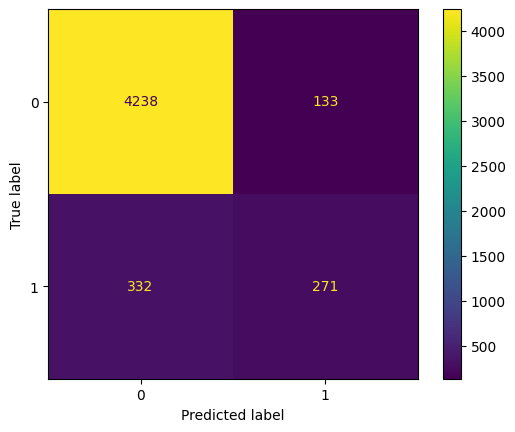

In [96]:
from sklearn.metrics import classification_report

predictions = best_model.predict(x_te,batch_size = 100,verbose=0)
rounded_predictions = (predictions > .5).astype(int)
nn_pred = confusion_matrix(y_te, rounded_predictions)
ConfusionMatrixDisplay(nn_pred).plot(cmap='viridis')
print(classification_report(y_te, rounded_predictions))


In [28]:
from pycaret.classification import *
import pandas as pd

x_tr,x_te,y_tr,y_te,bin_cat_encoded_tr,multi_cat_encoded_tr,bin_cat_encoded_te,multi_cat_encoded_te,training_data,numeric_tr,numeric_te = load_raw_data()
x_tr = data_transform(x_tr)
x_te = data_transform(x_te)

x_tr.reset_index(drop=True, inplace=True)
y_tr = pd.DataFrame(y_tr,columns = ["target"])
train = pd.concat([x_tr, y_tr], axis=1)

x_te.reset_index(drop=True, inplace=True)
y_te = pd.DataFrame(y_te,columns = ["target"])
test = pd.concat([x_te, y_te], axis=1)

data = pd.concat([train,test],axis = 0)
data.reset_index(drop = True, inplace = True)

clf1 = setup(data=data, target='target', session_id=123, experiment_name='Auto_ML')

# Compare models
best_model = compare_models()


,Description,Value
0,Session id,123
1,Target,target
2,Target type,Binary
3,Original data shape,"(49732, 48)"
4,Transformed data shape,"(49732, 48)"
5,Transformed train set shape,"(34812, 48)"
6,Transformed test set shape,"(14920, 48)"
7,Numeric features,47
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9154,0.9310,0.4549,0.7180,0.5567,0.5126,0.5290,0.7670
lightgbm,Light Gradient Boosting Machine,0.9077,0.9292,0.4738,0.6424,0.5453,0.4953,0.5024,0.5870
xgboost,Extreme Gradient Boosting,0.9074,0.9263,0.4773,0.6391,0.5463,0.4960,0.5026,0.2860
et,Extra Trees Classifier,0.9071,0.9135,0.4028,0.6706,0.5029,0.4552,0.4734,1.1700
gbc,Gradient Boosting Classifier,0.9063,0.9204,0.4173,0.6561,0.5100,0.4610,0.4755,1.6200
lr,Logistic Regression,0.9022,0.9069,0.3548,0.6484,0.4583,0.4096,0.4323,1.0110
ada,Ada Boost Classifier,0.8996,0.9058,0.3686,0.6177,0.4614,0.4099,0.4267,0.3930
lda,Linear Discriminant Analysis,0.8975,0.9046,0.3275,0.6149,0.4272,0.3766,0.3993,0.1090
svm,SVM - Linear Kernel,0.8969,0.8977,0.2412,0.6721,0.3516,0.3091,0.3590,0.0720
knn,K Neighbors Classifier,0.8962,0.8348,0.3413,0.5971,0.4341,0.3816,0.3999,1.3280


In [29]:
print(best_model)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=-1,
                       oob_score=False, random_state=123, verbose=0,
                       warm_start=False)


In [30]:
rf = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9136,0.9276,0.4595,0.6978,0.5541,0.5084,0.5221
1,0.9207,0.9283,0.4742,0.7569,0.5831,0.5418,0.5599
2,0.9265,0.9483,0.5099,0.7841,0.6179,0.5792,0.5957
3,0.9104,0.9255,0.3990,0.7043,0.5094,0.4642,0.4870
4,0.9144,0.9325,0.4606,0.7030,0.5565,0.5114,0.5255
5,0.9084,0.9305,0.4300,0.6679,0.5232,0.4751,0.4892
6,0.9161,0.9293,0.4423,0.7347,0.5521,0.5090,0.5290
7,0.9132,0.9244,0.4595,0.6952,0.5533,0.5074,0.5208
8,0.9164,0.9284,0.4595,0.7248,0.5624,0.5187,0.5352


In [31]:
tune_model(rf, return_tuner=True, optimize = "f1")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8194,0.8758,0.7690,0.3691,0.4988,0.4048,0.4454
1,0.8274,0.8932,0.8329,0.3888,0.5301,0.4410,0.4891
2,0.8190,0.8933,0.8103,0.3730,0.5109,0.4179,0.4653
3,0.7860,0.8736,0.8448,0.3346,0.4794,0.3749,0.4388
4,0.8236,0.8800,0.7906,0.3776,0.5111,0.4195,0.4622
5,0.8118,0.8653,0.8182,0.3643,0.5042,0.4085,0.4594
6,0.8294,0.8846,0.7813,0.3864,0.5171,0.4275,0.4666
7,0.8164,0.8794,0.8206,0.3711,0.5111,0.4173,0.4671
8,0.8173,0.8702,0.7690,0.3661,0.4960,0.4012,0.4425


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


(RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='sqrt',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_samples_leaf=1,
                        min_samples_split=2, min_weight_fraction_leaf=0.0,
                        monotonic_cst=None, n_estimators=100, n_jobs=-1,
                        oob_score=False, random_state=123, verbose=0,
                        warm_start=False),
 RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                    error_score=nan,
                    estimator=Pipeline(memory=Memory(location=None),
                                       steps=[('numerical_imputer',
                                               TransformerWrapper(exclude=None,
                                                                  include=['default',
                         

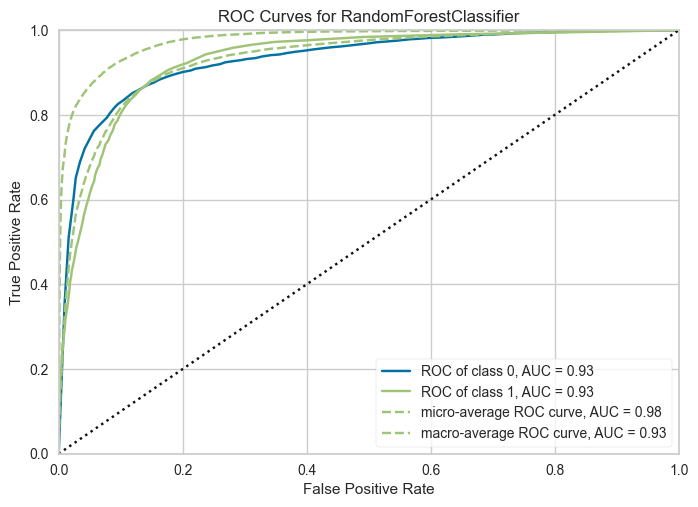

In [32]:
plot_model(rf)

#### Ensemble Model

In [34]:
models(type='ensemble').index.tolist()
ensembled_models = compare_models(include = models(type='ensemble').index.tolist(), fold = 5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9135,0.9288,0.4443,0.7069,0.5456,0.5006,0.5171,0.6200
xgboost,Extreme Gradient Boosting,0.9069,0.9244,0.4787,0.6347,0.5457,0.4950,0.5012,0.4800
lightgbm,Light Gradient Boosting Machine,0.9068,0.9279,0.4701,0.6374,0.5410,0.4905,0.4976,0.6360
gbc,Gradient Boosting Classifier,0.9060,0.9206,0.4128,0.6554,0.5064,0.4574,0.4725,2.2940
et,Extra Trees Classifier,0.9050,0.9096,0.3868,0.6591,0.4874,0.4389,0.4580,0.8560
ada,Ada Boost Classifier,0.8993,0.9061,0.3688,0.6154,0.4612,0.4094,0.4258,0.7700
